<a href="https://colab.research.google.com/github/Tamil-Ilakkiya1404/sentimental_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
def load_df(fp):
	df= pd.read_csv(fp, names=['id', 'ip', 'label', 'text']).set_index('id')
	df.drop_duplicates(inplace=True)
	df.dropna(inplace=True)
	df.info()
	return df

In [8]:
df_trn= load_df('twitter_training.csv')
print()
df_tst= load_df('twitter_validation.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 70958 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      70958 non-null  object
 1   label   70958 non-null  object
 2   text    70958 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3364 to 6960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      1000 non-null   object
 1   label   1000 non-null   object
 2   text    1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [11]:
df_trn.columns.tolist()

['ip', 'label', 'text']

In [12]:
df_tst.columns.tolist()

['ip', 'label', 'text']

In [13]:
df_trn.isnull().sum()

,0
ip,0
label,0
text,0


In [14]:
df_tst.isnull().sum()

,0
ip,0
label,0
text,0


In [15]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70958 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      70958 non-null  object
 1   label   70958 non-null  object
 2   text    70958 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [16]:
df_trn.describe()

,ip,label,text
count,70958,70958,70958
unique,32,4,69491
top,CallOfDuty,Negative,"At the same time, despite the fact that there ..."
freq,2304,21565,77


In [17]:
df_trn.sample(5)

,ip,label,text
id,,,
1808,CallOfDutyBlackopsColdWar,Neutral,Uhhhhhhhh... YUP you destiny has competition f...
6524,Fortnite,Positive,is
2020,CallOfDuty,Positive,@CallofDuty really outdid themselves with warz...
1302,Battlefield,Irrelevant,and ban for this Arena on GiantCrackRock had o...
1990,CallOfDutyBlackopsColdWar,Negative,Oh dear oh my computer is gonna run fried from...


In [18]:
df_trn['label'].value_counts()

,count
label,
Negative,21565
Positive,19549
Neutral,17398
Irrelevant,12446


In [19]:
df_trn= df_trn[df_trn['label']!='Irrelevant']
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58512 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      58512 non-null  object
 1   label   58512 non-null  object
 2   text    58512 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [20]:
nlp= spacy.load('en_core_web_sm')

In [21]:
def process_text(s):
	out= []
	for token in nlp(s):
		if not token.is_stop and not token.is_punct:
			out.append(token.lemma_)
	return ' '.join(out)

In [22]:
df_trn['fltr']= df_trn['text'].apply(process_text)

<ipython-input-22-59291a631d34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trn['fltr']= df_trn['text'].apply(process_text)


In [24]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=bfe9ce384a7c8885058540f71cadbeb3ab00c91d20f89ce1945cfb2b7129491f
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [25]:
from pandarallel import pandarallel

# Initialize Pandarallel
pandarallel.initialize()

# Apply process_text in parallel
df_trn['fltr'] = df_trn['text'].parallel_apply(process_text)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<ipython-input-25-83b439ee3a50>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trn['fltr'] = df_trn['text'].parallel_apply(process_text)


In [26]:
df_tst.sample(5)

,ip,label,text
id,,,
4272,CS-GO,Neutral,"CSGO, Road to Rio Predictions, North America\n..."
7950,MaddenNFL,Negative,@EAMaddenNFL when I first pre ordered it said ...
5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...
4438,Google,Neutral,The latest b_gardiner's Random Musings! paper....
11977,Verizon,Positive,"Exciting news! Verizon, Ericsson and Qualcomm ..."


In [28]:
# Fit the LabelEncoder on the combined unique labels from both training and test sets
enc = LabelEncoder()
enc.fit(pd.concat([df_trn['label'], df_tst['label']], ignore_index=True).unique())

# Transform the labels in the training and test sets
y_trn = enc.transform(df_trn['label'])
y_tst = enc.transform(df_tst['label'])

In [31]:
df_tst['text'].parallel_apply(process_text)
df_tst['fltr'] = df_tst['text'].parallel_apply(process_text)
vct= TfidfVectorizer()
X_trn= vct.fit_transform(df_trn['fltr'])
X_tst= vct.transform(df_tst['fltr'])

In [34]:
svc_model = SVC(kernel='linear')

# Train the model
svc_model.fit(X_trn, y_trn)

# Evaluate the model
accuracy = svc_model.score(X_tst, y_tst)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.78


In [37]:
y_pred=svc_model.predict(X_tst)
trnScore= svc_model.score(X_trn, y_trn)
tstScore= svc_model.score(X_tst, y_tst)
cm= confusion_matrix(y_tst, y_pred)
cr= classification_report(y_tst, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
print("Train Score:",trnScore)
print("Test Score:",tstScore)
print("Confusion Matrix:",cm)
print("Classification Report:",cr)

Train Score: 0.9093177467869838
Test Score: 0.78
Confusion Matrix: [[  0  64  42  66]
 [  0 252   3  11]
 [  0   7 268  10]
 [  0  10   7 260]]
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.76      0.95      0.84       266
           2       0.84      0.94      0.89       285
           3       0.75      0.94      0.83       277

    accuracy                           0.78      1000
   macro avg       0.59      0.71      0.64      1000
weighted avg       0.65      0.78      0.71      1000



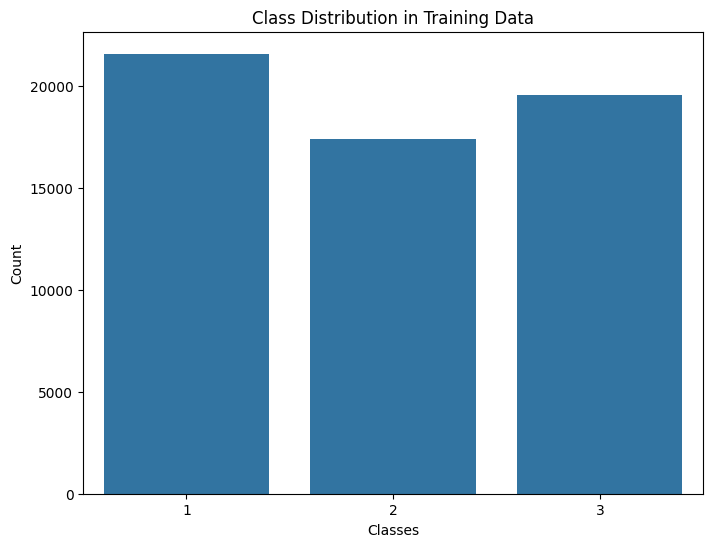

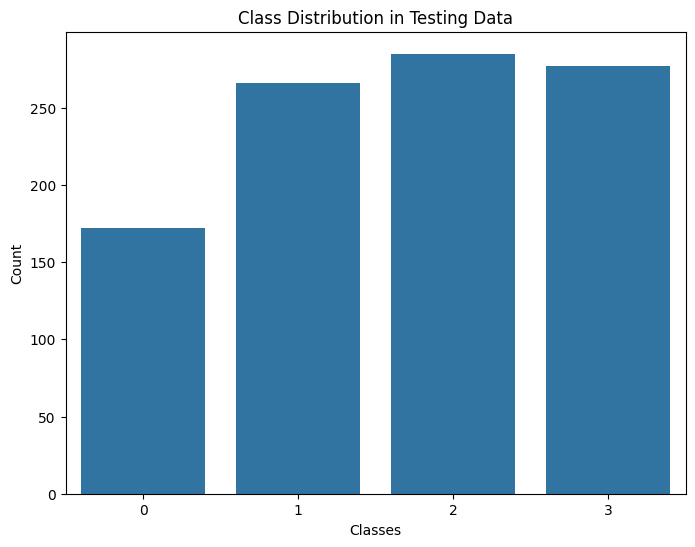

In [40]:
#training data distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_trn)
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# Testing data distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_tst)
plt.title('Class Distribution in Testing Data')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [41]:
import pickle

# Save the model
with open('svc_model.pkl', 'wb') as model_file:
    pickle.dump(svc_model, model_file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vct, vectorizer_file)

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


In [42]:
from google.colab import files

# Download the saved model and vectorizer files
files.download('svc_model.pkl')
files.download('vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>